In [1]:
import time

import pandas as pd

from crawler import Crawler,PropsFetchError,EmptyQueue,SubjectLog,urlkey
import bandits

In [2]:
def discover(subject,url0):
    max_size = 1000000
    log = SubjectLog(subject)
    bandit = bandits.Genealogist(log,max_size = max_size)
    #bandit = bandits.ClassyBandit(max_size = max_size)
    queue = Crawler(url0,subject,log,bandit)
    max_pages = 50 #maximal pages to consider (so including rejected)
    t0 = time.time()
    try:
        while not queue.done(max_pages,max_size) and time.time() < (t0 + 30):
            attempt = 0
            while (attempt := attempt + 1) <= 20:
                try: queue.pop().process()
                except PropsFetchError: 
                    log.nodes.append(pd.Series(name=urlkey(queue.current_url)),dtype=object)
                    print('props error ',queue.current_url)
                    continue
                break
            time.sleep(0.1) # don't want to freak out wikipedia
    except EmptyQueue:
        print('Exhausted links')
    log.plot(max_size)
    return log

downloaded  96290  of  1000000
downloaded  156567  of  1000000
downloaded  273847  of  1000000
downloaded  357781  of  1000000
downloaded  416312  of  1000000
downloaded  444775  of  1000000
downloaded  496434  of  1000000
downloaded  534047  of  1000000
downloaded  574563  of  1000000
downloaded  611259  of  1000000
downloaded  670840  of  1000000
downloaded  717587  of  1000000
downloaded  774261  of  1000000
downloaded  826325  of  1000000
downloaded  860223  of  1000000
downloaded  892450  of  1000000
downloaded  917713  of  1000000
downloaded  967258  of  1000000
downloaded  1018144  of  1000000


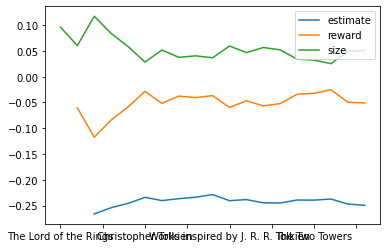

In [3]:
lotr = 'https://en.wikipedia.org/wiki/The_Lord_of_the_Rings'
res = discover('elves',lotr)